# Sistema de Recomendación de Películas
## Análisis de Datos y Machine Learning con API de TMDb

**Autores:** Chui, Meza, Pariona, Quino

Este notebook implementa un sistema completo de recomendación de películas que incluye:
- Recolección de datos desde la API de TMDb
- Análisis exploratorio de datos
- Sistema de recomendación basado en contenido
- Modelo predictivo de calificaciones
- Interfaz interactiva para el usuario

## Tabla de Contenidos

1. [Instalación de dependencias](#instalacion-dependencias)
2. [Funciones de verificación de entradas](#verificacion-entradas)
3. [Recolección de Datos](#recoleccion-datos)
4. [Análisis Exploratorio](#analisis-exploratorio)
5. [Preprocesamiento de Datos](#preprocesamiento-datos)
6. [Sistema de Recomendación](#sistema-recomendacion)
7. [Modelo Predictivo](#modelo-predictivo)
8. [Visualizaciones](#visualizaciones)
9. [Búsqueda Inteligente](#busqueda-inteligente)
10. [Función de corrección para actores, directores y productoras](#correccion-nombres)
11. [Interfaz Interactiva](#interfaz-interactiva)

## 0. Instalación de dependencias {#instalacion-dependencias}

In [2]:
%pip install pandas numpy scikit-learn matplotlib seaborn rapidfuzz

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Instalación de dependencias necesarias para todo el sistema (opcional alternativa)
def install_dependencies():
    import sys
    import subprocess
    pkgs = ["pandas", "numpy", "scikit-learn", "matplotlib", "seaborn", "rapidfuzz"]
    for pkg in pkgs:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
# install_dependencies()  # Descomenta si prefieres usar la función

## 0.5. Funciones de verificación de entradas {#verificacion-entradas}

In [4]:
# Funciones de validación de input

def input_nonempty(prompt):
    value = input(prompt).strip()
    while not value:
        print("La entrada no puede estar vacía. Intenta de nuevo.")
        value = input(prompt).strip()
    return value

def input_float(prompt):
    while True:
        try:
            value = float(input(prompt))
            return value
        except ValueError:
            print("Por favor, ingresa un número válido.")

def input_int(prompt):
    while True:
        try:
            value = int(input(prompt))
            return value
        except ValueError:
            print("Por favor, ingresa un número entero válido.")

In [5]:
! pip install rapidfuzz

In [ ]:
import requests
import pandas as pd
import time

# Tu API Key de TMDb
API_KEY = 'e8067df7340ce36be83b682382f969cd'

# Headers para autenticación (si usas token bearer)
# headers = {'Authorization': f'Bearer {TOKEN_JWT}'}

# Obtener lista de géneros disponibles
def obtener_generos():
    url = f'https://api.themoviedb.org/3/genre/movie/list?api_key={API_KEY}&language=en-US'
    r = requests.get(url)
    generos = r.json()['genres']
    return {g['id']: g['name'] for g in generos}

generos_dict = obtener_generos()

# Función para obtener detalles extra de una película
def obtener_detalles_pelicula(movie_id):
    url = f'https://api.themoviedb.org/3/movie/{movie_id}?api_key={API_KEY}&append_to_response=credits'
    r = requests.get(url)
    if r.status_code != 200:
        return None
    return r.json()

# Variables para almacenar info
peliculas = []

# Número de páginas a consultar (500 páginas = 10000 películas)
NUM_PAGES = 500

for page in range(1, NUM_PAGES + 1):
    print(f"Descargando página {page} de {NUM_PAGES}...")
    url = f'https://api.themoviedb.org/3/discover/movie?api_key={API_KEY}&language=en-US&sort_by=popularity.desc&page={page}'
    response = requests.get(url)
    if response.status_code != 200:
        continue

    movies_page = response.json()['results']

    for movie in movies_page:
        detalles = obtener_detalles_pelicula(movie['id'])
        if detalles is None:
            continue

        # Géneros
        generos = [generos_dict.get(g['id'], '') for g in detalles['genres']]

        # Cast (primeros 5)
        cast = [m['name'] for m in detalles['credits']['cast'][:5]]

        # Director
        director = next((m['name'] for m in detalles['credits']['crew'] if m['job'] == 'Director'), 'Unknown')

        # Productoras
        production_companies = [c['name'] for c in detalles.get('production_companies', [])]

        peliculas.append({
            'id': detalles['id'],
            'title': detalles['title'],
            'release_date': detalles['release_date'],
            'genres': generos,
            'overview': detalles.get('overview', ''),
            'popularity': detalles.get('popularity', 0),
            'runtime': detalles.get('runtime', 0),
            'production_companies': production_companies,
            'cast': cast,
            'director': director,
            'vote_average': detalles.get('vote_average', 0),
            'vote_count': detalles.get('vote_count', 0),
            'budget': detalles.get('budget', 0),
        })

    # Delay pequeño para no sobrecargar la API
    time.sleep(0.2)

# Convertir a DataFrame
df_api = pd.DataFrame(peliculas)

# Guardar en CSV
df_api.to_csv('dataset_movies_api.csv', index=False)
print(f"Películas descargadas: {len(df_api)}")


## 2. Análisis Exploratorio {#analisis-exploratorio}

Exploramos el dataset obtenido para entender su estructura y calidad:

In [6]:
import pandas as pd

# Cargar dataset descargado desde TMDb API
df_api = pd.read_csv('dataset_movies_api.csv')

# Mostrar las primeras 5 filas
df_api.head()


,id,title,release_date,genres,overview,popularity,runtime,production_companies,cast,director,vote_average,vote_count,budget
0,541671,Ballerina,2025-06-04,"['Action', 'Thriller', 'Crime']",Taking place during the events of John Wick: C...,759.5684,125,"['Thunder Road', '87Eleven', 'Lionsgate']","['Ana de Armas', 'Keanu Reeves', 'Ian McShane'...",Len Wiseman,7.337,649,90000000
1,986056,Thunderbolts*,2025-04-30,"['Action', 'Science Fiction', 'Adventure']",After finding themselves ensnared in a death t...,648.5939,127,"['Marvel Studios', 'Kevin Feige Productions']","['Florence Pugh', 'Sebastian Stan', 'Julia Lou...",Jake Schreier,7.400,1513,180000000
2,846422,The Old Guard 2,2025-07-01,"['Action', 'Fantasy']",Andy and her team of immortal warriors fight w...,677.2039,107,"['Skydance Media', 'Denver & Delilah Productio...","['Charlize Theron', 'KiKi Layne', 'Matthias Sc...",Victoria Mahoney,6.142,204,7000000
3,749170,Heads of State,2025-06-24,"['Action', 'Thriller', 'Comedy']",The UK Prime Minister and US President have a ...,523.0202,113,"['The Safran Company', 'Big Indie Pictures', '...","['Idris Elba', 'John Cena', 'Priyanka Chopra J...",Ilya Naishuller,7.031,162,0
4,1119878,Ice Road: Vengeance,2025-06-27,"['Action', 'Thriller', 'Drama']",Big rig ice road driver Mike McCann travels to...,495.5744,113,"['Code Entertainment', 'Shivhans Pictures', 'E...","['Liam Neeson', 'Fan Bingbing', 'Marcus Thomas...",Jonathan Hensleigh,6.898,49,0


In [7]:
df_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    9999 non-null   int64  
 1   title                 9999 non-null   object 
 2   release_date          9980 non-null   object 
 3   genres                9999 non-null   object 
 4   overview              9948 non-null   object 
 5   popularity            9999 non-null   float64
 6   runtime               9999 non-null   int64  
 7   production_companies  9999 non-null   object 
 8   cast                  9999 non-null   object 
 9   director              9999 non-null   object 
 10  vote_average          9999 non-null   float64
 11  vote_count            9999 non-null   int64  
 12  budget                9999 non-null   int64  
dtypes: float64(2), int64(4), object(7)
memory usage: 1015.7+ KB


In [8]:
# Convertir release_date a datetime
df_api['release_date'] = pd.to_datetime(df_api['release_date'], errors='coerce')

# Llenar overview nulos con texto vacío
df_api['overview'] = df_api['overview'].fillna('')

# Llenar director nulos (por precaución)
df_api['director'] = df_api['director'].fillna('Unknown')

# Eliminar duplicados por id o título
df_api = df_api.drop_duplicates(subset=['id'])

# Confirmar cambios
df_api.info()


<class 'pandas.core.frame.DataFrame'>
Index: 9874 entries, 0 to 9998
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    9874 non-null   int64         
 1   title                 9874 non-null   object        
 2   release_date          9856 non-null   datetime64[ns]
 3   genres                9874 non-null   object        
 4   overview              9874 non-null   object        
 5   popularity            9874 non-null   float64       
 6   runtime               9874 non-null   int64         
 7   production_companies  9874 non-null   object        
 8   cast                  9874 non-null   object        
 9   director              9874 non-null   object        
 10  vote_average          9874 non-null   float64       
 11  vote_count            9874 non-null   int64         
 12  budget                9874 non-null   int64         
dtypes: datetime64[ns](1), f

In [9]:
import ast  # Para convertir strings a listas

# Convertir columnas que son listas en string a listas reales
cols_listas = ['genres', 'cast', 'production_companies']

for col in cols_listas:
    df_api[col] = df_api[col].apply(ast.literal_eval)

df_api[['genres', 'cast']]

,genres,cast
0,"[Action, Thriller, Crime]","[Ana de Armas, Keanu Reeves, Ian McShane, Anje..."
1,"[Action, Science Fiction, Adventure]","[Florence Pugh, Sebastian Stan, Julia Louis-Dr..."
2,"[Action, Fantasy]","[Charlize Theron, KiKi Layne, Matthias Schoena..."
3,"[Action, Thriller, Comedy]","[Idris Elba, John Cena, Priyanka Chopra Jonas,..."
4,"[Action, Thriller, Drama]","[Liam Neeson, Fan Bingbing, Marcus Thomas, Gra..."
...,...,...
9994,"[Animation, Family, Adventure, Comedy]","[Jim Gaffigan, Zendaya, Lance Lim, Greg Proops..."
9995,"[Action, History, Drama]","[Andy Lau, Sammo Hung, Maggie Q, Damian Lau, T..."
9996,"[Comedy, Fantasy]","[Sharafudheen, Sandeep Pradeep, Suraj Venjaram..."
9997,"[Action, Comedy]","[Chen Bolin, Cecilia Choi, Kent Tsai Fan-Hsi, ..."


In [10]:
def crear_content_profile(row):
    genres = ' '.join(row['genres'])
    cast = ' '.join(row['cast'])
    companies = ' '.join(row['production_companies'])
    director = row['director']
    overview = row['overview']

    # Unimos todo en un string
    profile = f"{genres} {cast} {companies} {director} {overview}"
    return profile.lower()

# Crear nueva columna content_profile
df_api['content_profile'] = df_api.apply(crear_content_profile, axis=1)

# Verificar primeras filas
df_api[['title', 'content_profile']].head()


,title,content_profile
0,Ballerina,action thriller crime ana de armas keanu reeve...
1,Thunderbolts*,action science fiction adventure florence pugh...
2,The Old Guard 2,action fantasy charlize theron kiki layne matt...
3,Heads of State,action thriller comedy idris elba john cena pr...
4,Ice Road: Vengeance,action thriller drama liam neeson fan bingbing...


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Crear vectorizador TF-IDF
tfidf = TfidfVectorizer(
    max_features=5000,  # Limitar a 5000 términos más frecuentes
    stop_words='english',
    ngram_range=(1, 2),  # Unigramas y bigramas
    min_df=2,
    max_df=0.8
)

# Ajustar y transformar
tfidf_matrix = tfidf.fit_transform(df_api['content_profile'])

print(f"Matriz TF-IDF creada: {tfidf_matrix.shape}")


Matriz TF-IDF creada: (9874, 5000)


In [12]:
from sklearn.metrics.pairwise import cosine_similarity

# Calcular similitud coseno entre todas las películas
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Mostrar dimensiones
print(f"Matriz de similitud coseno: {cosine_sim.shape}")


Matriz de similitud coseno: (9874, 9874)


In [13]:
def get_movie_recommendations(title, cosine_sim=cosine_sim, df=df_api, num_recommendations=10):
    """
    Obtiene recomendaciones para una película específica
    """
    try:
        # Buscar índice de la película por título
        idx = df[df['title'].str.lower() == title.lower()].index[0]

        # Obtener puntuaciones de similitud para esa película
        sim_scores = list(enumerate(cosine_sim[idx]))

        # Ordenar por similitud de mayor a menor
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Obtener índices de las películas más similares (excluyendo la misma)
        movie_indices = [i[0] for i in sim_scores[1:num_recommendations+1]]

        # Crear DataFrame con resultados
        recommendations = df.iloc[movie_indices][['title', 'vote_average', 'popularity', 'release_date']].copy()
        recommendations['similarity_score'] = [score[1] for score in sim_scores[1:num_recommendations+1]]

        return recommendations

    except IndexError:
        print(f"Película '{title}' no encontrada en el dataset")
        return None


In [14]:
get_movie_recommendations("Spider-man")

,title,vote_average,popularity,release_date,similarity_score
378,Spider-Man 3,6.439,14.6094,2007-05-01,0.531397
2102,Spider-Man 2,7.294,5.4605,2004-06-25,0.503755
192,Spider-Man: Across the Spider-Verse,8.346,21.0453,2023-05-31,0.301172
405,Spider-Man: Into the Spider-Verse,8.399,16.1320,2018-12-06,0.297763
252,Spider-Man: Homecoming,7.331,18.0334,2017-07-05,0.271681
3224,Spider-Man: Brand New Day,0.000,4.5471,2026-07-29,0.264232
383,The Amazing Spider-Man,6.717,12.9155,2012-06-23,0.253911
586,The Amazing Spider-Man 2,6.520,9.4079,2014-04-16,0.230625
156,Spider-Man: No Way Home,7.943,24.4448,2021-12-15,0.211662
4060,Spider-Man: Beyond the Spider-Verse,0.000,3.6576,2027-06-02,0.178860


In [15]:
import numpy as np

def evaluate_recommendations(sample_size=100, num_recommendations=10):
    """
    Evalúa la diversidad promedio de géneros en las recomendaciones
    """
    recommendations_diversity = []

    # Tomar muestra aleatoria de títulos
    sample_movies = df_api.sample(sample_size)['title'].tolist()

    for movie in sample_movies:
        recs = get_movie_recommendations(movie, num_recommendations=num_recommendations)
        if recs is not None:
            # Obtener índices de películas recomendadas
            rec_titles = recs['title'].tolist()
            rec_genres = []

            # Extraer géneros de las películas recomendadas
            for title in rec_titles:
                idx = df_api[df_api['title'] == title].index
                if not idx.empty:
                    rec_genres.extend(df_api.loc[idx[0], 'genres'])

            # Contar géneros únicos
            unique_genres = len(set(rec_genres))
            recommendations_diversity.append(unique_genres)

    # Promediar diversidad de géneros
    avg_diversity = np.mean(recommendations_diversity)
    print(f"Diversidad promedio de géneros en recomendaciones: {avg_diversity:.2f}")

    return avg_diversity


In [16]:
# Extraer release_year
df_api['release_year'] = df_api['release_date'].dt.year

# Número de géneros
df_api['num_genres'] = df_api['genres'].apply(len)

# Número de actores en cast
df_api['num_cast'] = df_api['cast'].apply(len)

# Confirmar
df_api[['title', 'release_year', 'num_genres', 'num_cast']].head()


,title,release_year,num_genres,num_cast
0,Ballerina,2025.0,3,5
1,Thunderbolts*,2025.0,3,5
2,The Old Guard 2,2025.0,2,5
3,Heads of State,2025.0,3,5
4,Ice Road: Vengeance,2025.0,3,5


In [17]:
# Definir variables predictoras y objetivo
feature_columns = ['budget', 'popularity', 'runtime', 'release_year', 'num_genres', 'num_cast']
X = df_api[feature_columns]
y = df_api['vote_average']

# Eliminar registros con nulos
df_model = df_api[feature_columns + ['vote_average']].dropna()
X = df_model[feature_columns]
y = df_model['vote_average']

print(f"Películas usadas para modelado: {X.shape[0]}")


Películas usadas para modelado: 9856


In [18]:
from sklearn.model_selection import train_test_split

# Separar en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Películas de entrenamiento: {X_train.shape[0]}")
print(f"Películas de prueba: {X_test.shape[0]}")


Películas de entrenamiento: 7884
Películas de prueba: 1972


In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Preprocesador: solo numéricas, así que escalamos todas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_columns)
    ]
)

# Pipeline Regresión Lineal
linear_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Pipeline Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

# Entrenar modelos
linear_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)

# Predicciones
y_pred_linear = linear_pipeline.predict(X_test)
y_pred_rf = rf_pipeline.predict(X_test)

# Métricas
def evaluar_modelo(y_test, y_pred, nombre):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{nombre}: MAE={mae:.3f}, RMSE={rmse:.3f}, R²={r2:.3f}")
    return mae, rmse, r2

# Evaluar ambos modelos
mae_lin, rmse_lin, r2_lin = evaluar_modelo(y_test, y_pred_linear, "Regresión Lineal")
mae_rf, rmse_rf, r2_rf = evaluar_modelo(y_test, y_pred_rf, "Random Forest")


Regresión Lineal: MAE=0.767, RMSE=1.127, R²=0.149
Random Forest: MAE=0.665, RMSE=1.000, R²=0.330


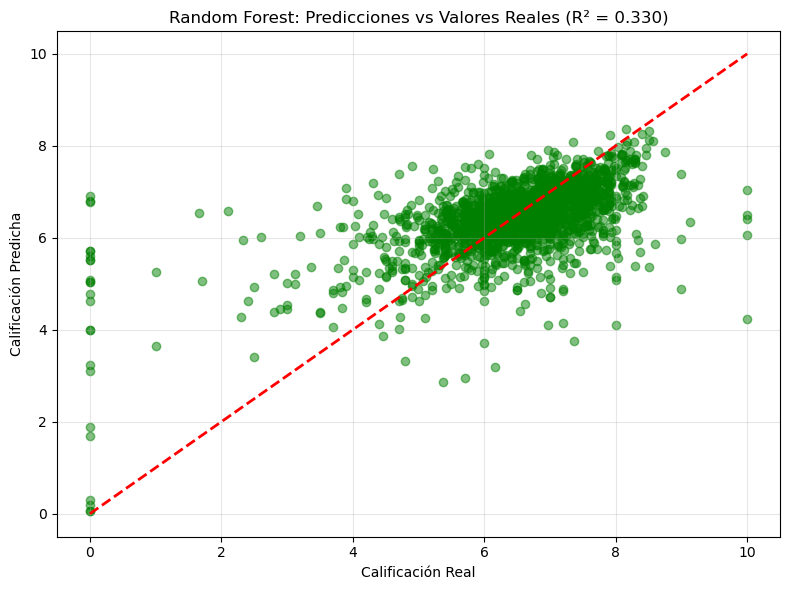

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Calificación Real')
plt.ylabel('Calificación Predicha')
plt.title(f'Random Forest: Predicciones vs Valores Reales (R² = {r2_rf:.3f})')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


C:\Users\yamir\AppData\Local\Temp\ipykernel_8280\2971836926.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importancia_df, x='Importancia', y='Variable', palette='viridis')


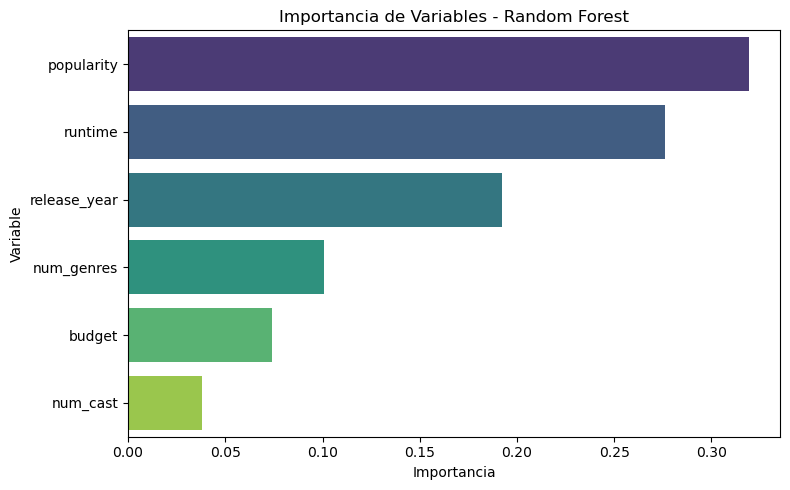

In [21]:
import seaborn as sns
import pandas as pd

# Obtener importancia de variables
importancias = rf_pipeline.named_steps['regressor'].feature_importances_
nombres_variables = feature_columns

# Crear DataFrame
importancia_df = pd.DataFrame({
    'Variable': nombres_variables,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

# Graficar
plt.figure(figsize=(8, 5))
sns.barplot(data=importancia_df, x='Importancia', y='Variable', palette='viridis')
plt.title('Importancia de Variables - Random Forest')
plt.tight_layout()
plt.show()


In [187]:
def buscar_peliculas_similares(query, num_recommendations=10):
    # Corregir ortografía del título si es posible
    query_corregido = corregir_titulo_input(query) if query.strip() else query

    # Vectorizar consulta del usuario
    query_vec = query_vectorizer.transform([query_corregido.lower()])

    # Calcular similitud coseno contra todas las películas
    sim_scores = cosine_similarity(query_vec, tfidf_matrix).flatten()

    # Buscar si hay coincidencia exacta (case-insensitive)
    idx_exact = df_api[df_api['title'].str.lower() == query_corregido.lower()].index
    movie_indices = sim_scores.argsort()[-num_recommendations:][::-1]

    # Si hay coincidencia exacta, ponerla primero y completar con el resto (sin duplicados)
    if not idx_exact.empty:
        idx_exact = idx_exact[0]
        indices_finales = [idx_exact] + [i for i in movie_indices if i != idx_exact][:num_recommendations-1]
    else:
        indices_finales = movie_indices[:num_recommendations]

    # Crear DataFrame con resultados
    recommendations = df_api.iloc[indices_finales][['title', 'vote_average', 'release_date']].copy()
    recommendations['similarity_score'] = sim_scores[indices_finales]

    return recommendations

In [189]:
buscar_peliculas_similares("bullet train")

,title,vote_average,release_date,similarity_score
531,Bullet Train,7.436,2022-08-03,0.176653
9493,The Bullet Train,6.800,1975-07-05,0.556920
1792,Kill,7.190,2024-07-03,0.403890
7905,Red Sun,6.908,1971-09-15,0.366150
1286,Ellie and the Monster Team,6.050,2024-06-27,0.336925
4533,Captive Women 4,4.900,1977-09-26,0.307447
6297,Chariots of Fire,6.787,1981-05-15,0.307442
9951,Bullet Train Down,5.538,2022-08-01,0.302136
7192,SAS: Red Notice,5.802,2021-08-11,0.281557
7368,The Lady Vanishes,7.444,1938-10-07,0.265213


In [24]:
! pip install rapidfuzz

In [25]:
import re
import unicodedata

def normalize_text(s):
    """Minúsculas, sin signos de puntuación ni acentos, guiones o espacios extra."""
    # 1. Quitar acentos
    s = unicodedata.normalize('NFKD', s).encode('ASCII', 'ignore').decode()
    # 2. Pasa a minúsculas
    s = s.lower()
    # 3. Reemplaza todo lo que no sea letra/número con espacio
    s = re.sub(r'[^a-z0-9]+', ' ', s)
    # 4. Colapsa múltiples espacios
    s = re.sub(r'\s+', ' ', s).strip()
    return s

In [26]:
from collections import defaultdict

# Mapeos normalizado → índices de df_api
actor_index    = defaultdict(set)
director_index = defaultdict(set)
company_index  = defaultdict(set)

for idx, row in df_api.iterrows():
    # Cast
    for actor in row['cast']:
        na = normalize_text(actor)
        actor_index[na].add(idx)
    # Director
    nd = normalize_text(row['director'])
    director_index[nd].add(idx)
    # Productoras
    for comp in row['production_companies']:
        nc = normalize_text(comp)
        company_index[nc].add(idx)

In [27]:
# Lista con títulos originales
titulos_originales = df_api['title'].tolist()

# Diccionario: normalizado → lista de originales (por si hay duplicados normalizados)
norm_to_titles = {}
for t in titulos_originales:
    nt = normalize_text(t)
    norm_to_titles.setdefault(nt, []).append(t)

# Lista de claves normalizadas para fuzzy
titulos_norm = list(norm_to_titles.keys())

In [171]:
from rapidfuzz import process, fuzz

def corregir_titulo_input(titulo_input, threshold=70):
    """
    Corrige la entrada del usuario buscando el título normalizado más cercano.
    """
    # Normaliza la entrada
    ni = normalize_text(titulo_input)

    # Busca en las claves normalizadas
    resultado = process.extractOne(
        ni,
        titulos_norm,
        scorer=fuzz.token_sort_ratio
    )
    if resultado and resultado[1] >= threshold:
        key_norm = resultado[0]
        # Si hay varios títulos originales para esa clave, elige el de mayor similitud sobre originales
        originales = norm_to_titles[key_norm]
        if len(originales) == 1:
            return originales[0]
        # Desempate: vuelve a medir directamente sobre títulos originales
        best = process.extractOne(
            titulo_input,
            originales,
            scorer=fuzz.token_sort_ratio
        )
        return best[0]
    return None

In [169]:
for prueba in [
    "spderman no way home",
    "spiderman into the spiderverse",
    "batmn begins",
    "Batman Begins",
    "avator",
    "thnderbolts",
    "avetar",
    "dragon bll",
    "Dragon ball",
    "Dragon ball: Revolution",
    "bullet trai"
]:
    cor = corregir_titulo_input(prueba)
    print(f"{prueba!r}  →  {cor!r}")

'spderman no way home'  →  'Spider-Man: No Way Home'
'spiderman into the spiderverse'  →  'Spider-Man: Into the Spider-Verse'
'batmn begins'  →  'Batman Begins'
'Batman Begins'  →  'Batman Begins'
'avator'  →  'Avatar'
'thnderbolts'  →  'Thunderbolts*'
'avetar'  →  'Avatar'
'dragon bll'  →  'Dragon Blade'
'Dragon ball'  →  'Dragon Blade'
'Dragon ball: Revolution'  →  'Dragonball Evolution'
'bullet trai'  →  'Bullet Train'


In [77]:
from rapidfuzz import process, fuzz

# Listas de nombres normalizados para fuzzy matching
actor_names = list(actor_index.keys())
director_names = list(director_index.keys())
company_names = list(company_index.keys())

def corregir_nombre_entidad(nombre, entidad, threshold=75):
    """
    Corrige el nombre de actor, director o productora usando fuzzy matching.
    entidad: 'actor', 'director', 'company'
    """
    nombre_norm = normalize_text(nombre)
    if entidad == 'actor':
        candidates = actor_names
    elif entidad == 'director':
        candidates = director_names
    elif entidad == 'company':
        candidates = company_names
    else:
        return nombre_norm
    resultado = process.extractOne(nombre_norm, candidates, scorer=fuzz.token_sort_ratio)
    if resultado and resultado[1] >= threshold:
        return resultado[0]
    return nombre_norm

In [209]:
def buscar_inteligente(
    pelicula="",
    actores="",
    directores="",
    productoras="",
    top_n=10
):
    """
    Búsqueda inteligente con campos explícitos.
    - pelicula: string de palabras clave o título (puede estar vacío)
    - actores: string separado por comas con nombres de actores (puede estar vacío)
    - directores: string separado por comas con nombres de directores (puede estar vacío)
    - productoras: string separado por comas con nombres de productoras (puede estar vacío)
    Aplica corrección ortográfica a actores, directores y productoras.
    La corrección de título se realiza en buscar_peliculas_similares.
    Prioriza coincidencia exacta si existe.
    """
    # Filtrado por actores
    idxs = None
    if actores.strip():
        actores_lista = [corregir_nombre_entidad(a.strip(), 'actor') for a in actores.split(',') if a.strip()]
        sets = [actor_index[a] for a in actores_lista if a in actor_index]
        if sets:
            idxs = set.intersection(*sets) if len(sets) > 1 else sets[0].copy()
        else:
            idxs = set()
    # Filtrado por directores
    if directores.strip():
        directores_lista = [corregir_nombre_entidad(d.strip(), 'director') for d in directores.split(',') if d.strip()]
        sets = [director_index[d] for d in directores_lista if d in director_index]
        if sets:
            idxs = (idxs & set.intersection(*sets)) if idxs is not None else set.intersection(*sets)
        else:
            idxs = set() if idxs is None else set()
    # Filtrado por productoras
    if productoras.strip():
        productoras_lista = [corregir_nombre_entidad(p.strip(), 'company') for p in productoras.split(',') if p.strip()]
        sets = [company_index[p] for p in productoras_lista if p in company_index]
        if sets:
            idxs = (idxs & set.intersection(*sets)) if idxs is not None else set.intersection(*sets)
        else:
            idxs = set() if idxs is None else set()

    # Si no hay ningún filtro, usar búsqueda semántica global
    if idxs is None or not idxs:
        return buscar_peliculas_similares(pelicula, num_recommendations=top_n)

    # Ranking semántico dentro del subconjunto filtrado
    q_vec = tfidf.transform([pelicula.lower()]) if pelicula.strip() else tfidf.transform([""])
    idx_list = list(idxs)
    sims = cosine_similarity(q_vec, tfidf_matrix[idx_list]).flatten()
    ranked = sorted(
        zip(idx_list, sims),
        key=lambda x: x[1],
        reverse=True
    )
    resultados_idx = [i for i, _ in ranked][:top_n]

    # Prioriza coincidencia exacta en el subconjunto filtrado
    idx_exact = [i for i in resultados_idx if df_api.iloc[i]['title'].lower() == pelicula.lower()]
    if idx_exact:
        resultados_idx = idx_exact + [i for i in resultados_idx if i not in idx_exact]
        resultados_idx = resultados_idx[:top_n]

    recs = df_api.iloc[resultados_idx][['title','vote_average','release_date']].copy()
    recs['similarity_score'] = [
        cosine_similarity(q_vec, tfidf_matrix[[i]]).flatten()[0]
        for i in resultados_idx
    ]
    return recs

In [210]:
buscar_inteligente(
    pelicula="bullet train",
    actores="",
    directores=""
)

,title,vote_average,release_date,similarity_score
531,Bullet Train,7.436,2022-08-03,0.176653
9493,The Bullet Train,6.800,1975-07-05,0.556920
1792,Kill,7.190,2024-07-03,0.403890
7905,Red Sun,6.908,1971-09-15,0.366150
1286,Ellie and the Monster Team,6.050,2024-06-27,0.336925
4533,Captive Women 4,4.900,1977-09-26,0.307447
6297,Chariots of Fire,6.787,1981-05-15,0.307442
9951,Bullet Train Down,5.538,2022-08-01,0.302136
7192,SAS: Red Notice,5.802,2021-08-11,0.281557
7368,The Lady Vanishes,7.444,1938-10-07,0.265213


In [39]:
def predict_movie_rating(budget, popularity, runtime, year, num_genres, num_cast, genre, language):
    """
    Función auxiliar para predecir calificación usando el modelo entrenado
    """
    # Crear DataFrame con los datos de entrada
    import pandas as pd
    input_data = pd.DataFrame({
        'budget': [budget],
        'popularity': [popularity], 
        'runtime': [runtime],
        'release_year': [year],
        'num_genres': [num_genres],
        'num_cast': [num_cast]
    })
    
    # Hacer predicción
    prediction = rf_pipeline.predict(input_data)[0]
    print(f"Calificación predicha: {prediction:.2f}/10")
    return prediction

def interactive_movie_system():
    """Sistema interactivo para recomendaciones y predicciones"""
    print("=== SISTEMA DE RECOMENDACIÓN DE PELÍCULAS ===")

    while True:
        print("\n1. Obtener recomendaciones")
        print("2. Predecir calificación de película")
        print("3. Búsqueda inteligente")
        print("4. Salir")

        choice = input("Selecciona una opción: ")

        if choice == '1':
            movie_title = input("Ingresa el título de una película: ")
            # Intentar corregir el título primero
            corrected_title = corregir_titulo_input(movie_title)
            if corrected_title:
                print(f"Título corregido: {corrected_title}")
                recommendations = get_movie_recommendations(corrected_title)
            else:
                recommendations = get_movie_recommendations(movie_title)
                
            if recommendations is not None:
                print(f"\nRecomendaciones para '{movie_title}':")
                print(recommendations[['title', 'vote_average', 'similarity_score']])
            else:
                print("No se encontraron recomendaciones para esa película.")
                print("Sugerencia: prueba la opción de Búsqueda Inteligente para encontrar resultados relacionados.")

        elif choice == '2':
            try:
                budget = float(input("Presupuesto (USD): "))
                popularity = float(input("Popularidad (0-100): "))
                runtime = float(input("Duración (minutos): "))
                year = int(input("Año de lanzamiento: "))
                num_genres = int(input("Número de géneros: "))
                num_cast = int(input("Número de actores principales: "))
                genre = input("Género principal: ")
                language = input("Idioma original: ")

                prediction = predict_movie_rating(
                    budget, popularity, runtime, year,
                    num_genres, num_cast, genre, language
                )

            except ValueError:
                print("Por favor, ingresa valores válidos.")

        elif choice == '3':
            query = input("Ingresa tu búsqueda (actor, director, productora, etc.): ")
            results = buscar_inteligente(query)
            if results is not None and len(results) > 0:
                print(f"\nResultados para '{query}':")
                print(results[['title', 'vote_average', 'similarity_score']])
            else:
                print("No se encontraron resultados para esa búsqueda.")

        elif choice == '4':
            print("¡Gracias por usar el sistema de recomendación!")
            break
        else:
            print("Opción inválida.")

# Ejecutar el sistema interactivo
# interactive_movie_system()

In [40]:
def interactive_movie_system_robust():
    print("=== SISTEMA DE RECOMENDACIÓN DE PELÍCULAS (Robusto) ===")
    while True:
        print("\n1. Obtener recomendaciones por título")
        print("2. Predecir calificación de película (plus)")
        print("3. Búsqueda inteligente")
        print("4. Salir")
        choice = input_nonempty("Selecciona una opción: ")
        if choice == '1':
            movie_title = input_nonempty("Ingresa el título de una película: ")
            corrected_title = corregir_titulo_input(movie_title)
            if corrected_title:
                print(f"Título corregido: {corrected_title}")
                recommendations = get_movie_recommendations(corrected_title)
            else:
                recommendations = get_movie_recommendations(movie_title)
            if recommendations is not None:
                print(f"\nRecomendaciones para '{movie_title}':")
                print(recommendations[['title', 'vote_average', 'similarity_score']])
            else:
                print("No se encontraron recomendaciones para esa película.")
                print("Sugerencia: prueba la opción de Búsqueda Inteligente para encontrar resultados relacionados.")
        elif choice == '2':
            try:
                budget = input_float("Presupuesto (USD): ")
                popularity = input_float("Popularidad (0-100): ")
                runtime = input_float("Duración (minutos): ")
                year = input_int("Año de lanzamiento: ")
                num_genres = input_int("Número de géneros: ")
                num_cast = input_int("Número de actores principales: ")
                genre = input_nonempty("Género principal: ")
                language = input_nonempty("Idioma original: ")
                prediction = predict_movie_rating(
                    budget, popularity, runtime, year,
                    num_genres, num_cast, genre, language
                )
            except Exception as e:
                print(f"Error en la predicción: {e}")
        elif choice == '3':
            query = input_nonempty("Ingresa tu búsqueda (actor, director, productora, etc.): ")
            results = buscar_inteligente(query)
            if results is not None and len(results) > 0:
                print(f"\nResultados para '{query}':")
                print(results[['title', 'vote_average', 'similarity_score']])
            else:
                print("No se encontraron resultados para esa búsqueda.")
        elif choice == '4':
            print("¡Gracias por usar el sistema de recomendación!")
            break
        else:
            print("Opción inválida.")

# Para usar el menú robusto, descomenta:
# interactive_movie_system_robust()